In [1]:
import thermopyl as th
from thermopyl import thermoml_lib
import cirpy
import numpy as np
import pandas as pd
import itertools

import functools
from functools import reduce
from os.path import expanduser
from joblib import Memory

"""
Получить мольные доли компонентов и давление. CO2 и n-Decan. CO2 обычно идет вторым.
Построить зависимость мольного соотношения от давления.
"""

'\nПолучить мольные доли компонентов и давление. CO2 и n-Decan. CO2 обычно идет вторым.\nПостроить зависимость мольного соотношения от давления.\n'

In [2]:
home = expanduser("~")
desired_components = ['carbon dioxide', 'n-dodecane']
df = th.pandas_dataframe()
mem = Memory(location=home+"/.thermoml/")

@mem.cache
def resolve_cached(x, rtype):
   return cirpy.resolve(x, rtype)
    
# experiments=['Mole fraction']
# ind_list = [df[exp].dropna().index for exp in experiments]
# ind = reduce(lambda x, y: x.union(y), ind_list)


name_to_formula = pd.read_parquet("~/.thermoml/compound_name_to_formula.pq").dropna()
# ind_list
# ind
# name_to_formula

def feature_occurency(df, feature):
    dt = list(df.columns)
    col_list = [colname for colname in dt if feature in colname]
    print(f'Dataframe size: {len(df)}')
    for substring in col_list:
        print(f'Number of "{substring}" entries: {len(df)-df[substring].isnull().sum()}')
        
feature_occurency(df, 'Mole fraction')

Dataframe size: 382763
Number of "Mole fraction" entries: 348552
Number of "Mole fraction_std" entries: 0
Number of "Solvent: Mole fraction" entries: 37498
Number of "Mole fraction Variable metadata" entries: 188076
Number of "Mole fraction metadata" entries: 2707


In [25]:

# Function to find all mixtures containing a specific component
def find_mixtures_with_component(df, component):
    components = df['components'].unique()

    # Split the mixtures into separate components
    components_split = pd.Series(components).str.split('__')
    
    # Flatten the list of lists and get unique components
    unique_components = set([item for sublist in components_split for item in sublist])
    
    # Convert to a sorted list if needed
    unique_components = sorted(unique_components)
    
    # print(len(unique_components))

    # return df[df['components'].apply(lambda x: component in x.split('_'))]
    return df[df['components'].apply(lambda x: component in x.split('__'))]['components'].unique()

# Example usage
specific_component = 'hydrogen sulfide'  # Replace with the actual component name
mixtures_with_component = find_mixtures_with_component(df, specific_component)

print(len(mixtures_with_component))
print('\n'.join(mixtures_with_component))


40
hydrogen sulfide__.beta.,.beta.'-dihydroxydiethyl sulfide
1-dodecyl-1H-imidazole__hydrogen sulfide
hydrogen sulfide__1,1'-[oxybis(2,1-ethanediyloxy-2,1-ethane-diyl)]bis-(1H-imidazole)
carbon dioxide__hydrogen sulfide__1-octyl-3-methylimidazolium hexafluorophosphate
hydrogen sulfide__1-octyl-3-methylimidazolium hexafluorophosphate
4-methyl-1,3-dioxolan-2-one__hydrogen sulfide
carbon dioxide__hydrogen sulfide__1-butyl-3-methylimidazolium acetate
hydrogen sulfide__1-butyl-3-methylimidazolium hexafluorophosphate
carbon dioxide__hydrogen sulfide__1-butyl-3-methylimidazolium hexafluorophosphate
hydrogen sulfide__1-(2-hydroxyethyl)-3-methylimidazolium tetrafluoroborate
hydrogen sulfide
2-thiabutane__hydrogen sulfide
carbon disulfide__hydrogen sulfide
2-thiapropane__hydrogen sulfide
decafluorobutane__hydrogen sulfide
carbon dioxide__hydrogen sulfide
hydrogen sulfide__3-(2-hydroxyethyl)-1-methylimidazolium hexafluorophosphate
hydrogen sulfide__3-(2-hydroxyethyl)-1-methylimidazolium 1,1,1-tri

In [3]:
# desired_components = ['InChI=1S/CO2/c2-1-3', 'InChI=1S/C10H22/c1-3-5-7-9-10-8-6-4-2/h3-10H2,1-2H3']
desired_components = ['decane', 'carbon dioxide']

def find_permutations(df, lst):
    # Generate all possible permutations of the strings in the list
    permutations = ['__'.join(comb) for comb in itertools.permutations(lst)]
    
    # Find all entries in the DataFrame where 'components' equals to any of the permutations
    print(f'Looking for mixtures: {permutations}')
    result = df[df['components'].isin(permutations)]
    
    return result
    
df['n_components'] = df['components'].str.split('__').str.len()
df_merged = find_permutations(df, desired_components)

print(len(df_merged))

Looking for mixtures: ['decane__carbon dioxide', 'carbon dioxide__decane']
198


In [4]:
feature_occurency(df_merged, 'Mole fraction')
feature_occurency(df_merged, 'Pressure')
feature_occurency(df_merged, 'Temperature')

Dataframe size: 198
Number of "Mole fraction" entries: 186
Number of "Mole fraction_std" entries: 0
Number of "Solvent: Mole fraction" entries: 0
Number of "Mole fraction Variable metadata" entries: 145
Number of "Mole fraction metadata" entries: 0
Dataframe size: 198
Number of "Pressure, kPa" entries: 77
Dataframe size: 198
Number of "Temperature, K" entries: 197


In [5]:
def filter_dataframe(df: pd.DataFrame, *keywords: str) -> pd.DataFrame:
    # Create a copy of the dataframe to avoid modifying the original one
    df_filtered = df.copy()
    
    # Iterate over each keyword
    for keyword in keywords:
        # Check if the keyword is a column in the dataframe
        if keyword in df.columns:
            # Filter rows where the column value is not None
            df_filtered = df_filtered[df_filtered[keyword].notna()]
    
    return df_filtered

main_features = []#["Mole fraction", "Pressure, kPa", "Temperature, K"]
df_filtered = filter_dataframe(df_merged, *main_features)
print(len(df_filtered))

198


In [6]:
# print(*list(df_filtered.columns), sep="\n")
# print(df_filtered.filename.nunique())
for feature in main_features + ['filename']:
    print(f'Number of different "{feature}": {df_filtered[feature].nunique()}')
print(df_filtered['filename'].unique())

Number of different "filename": 6
['./mixture_data/acs.jced.7b00517.xml'
 './mixture_data/j.fluid.2012.09.037.xml' './mixture_data/je060111z.xml'
 './mixture_data/j.jct.2012.08.019.xml'
 './mixture_data/j.fluid.2016.03.010.xml' './mixture_data/je4000394.xml']


In [7]:
print(df_filtered['filename'].iloc[-1])
print(df_filtered['Temperature, K'].iloc[-1])
for entry in df_filtered.iloc:
    if entry.n_components == 3:
        print(entry.components)
        # for some in entry:
        #     print(some)
        break


./mixture_data/je4000394.xml
323.2


(198, 130)


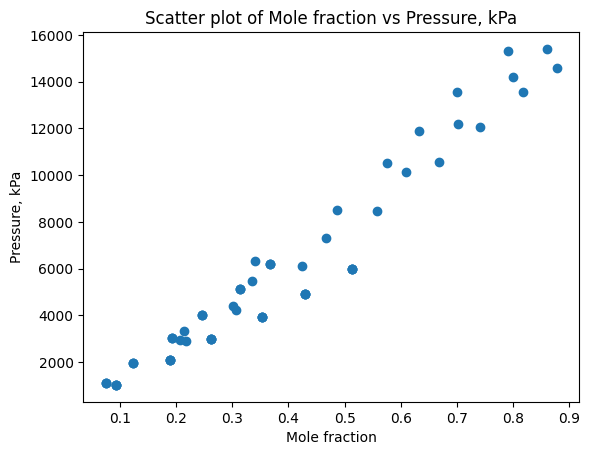

In [8]:
import matplotlib.pyplot as plt
def plot2(df, f_comp, s_comp):
    plt.scatter(df[f_comp], df[s_comp])
    print(df_filtered.shape)
    plt.xlabel(f_comp)
    plt.ylabel(s_comp)
    plt.title(f'Scatter plot of {f_comp} vs {s_comp}')
    
    plt.show()


f_comp = 'Mole fraction'
s_comp = 'Pressure, kPa'
df = df_filtered
plot2(df, f_comp, s_comp)

In [9]:
'''
if no pressure column then use vapor_or_sublimation_pressure
if pressure for gasa no stated then use pressure for liquid
Mole_fraction
Mass_density
в первую очередь сделать так, чтобы давление было в одной колонке для всех данных
отдельно записи, где мольная доля дана для жидкости и где для газа
N рядов с данными для жидкостной части и столько же для газовой. Нужно придумать, как склеить (сверяться с работами)
'''


'\nif no pressure column then use vapor_or_sublimation_pressure\nif pressure for gasa no stated then use pressure for liquid\nMole_fraction\nMass_density\nв первую очередь сделать так, чтобы давление было в одной колонке для всех данных\nотдельно записи, где мольная доля дана для жидкости и где для газа\nN рядов с данными для жидкостной части и столько же для газовой. Нужно придумать, как склеить (сверяться с работами)\n'

In [10]:
def strip_none_columns(df):
    return df.copy().dropna(axis=1, how='all').reset_index(drop=True)
    
filenames = df_filtered['filename'].unique()
print(filenames)
# Divide each dataset in corresponding number of consequent parts and merge data at corresponding indeces
folds = [2, 3, 2, 3, -1, 3]
"""
For ./mixture_data/j.fluid.2016.03.010.xml need to find all entries with the same temperature and mole fraction
"""
df_test = df_filtered[df_filtered['filename'] == filenames[2]]
df_test = strip_none_columns(df_test)
print(f"n_temps: {len(df_test['Temperature, K'].unique())}")
# print(f"n_press: {len(df_test['Pressure, kPa'].unique())}")
# print(f"n_press: {len(df_test['Vapor or sublimation pressure, kPa'].unique())}")
rows, cols = df_test.shape
print(f"Number of rows: {rows}\nNumber of columns: {cols}")
print(list(df_test.columns))
df_test

['./mixture_data/acs.jced.7b00517.xml'
 './mixture_data/j.fluid.2012.09.037.xml' './mixture_data/je060111z.xml'
 './mixture_data/j.jct.2012.08.019.xml'
 './mixture_data/j.fluid.2016.03.010.xml' './mixture_data/je4000394.xml']
n_temps: 3
Number of rows: 58
Number of columns: 12
['filename', 'components', 'component_1_inchi', 'component_2_inchi', 'Temperature, K', 'Mole fraction', 'phase', 'component_3_inchi', 'component_4_inchi', 'Vapor or sublimation pressure, kPa', 'Mole fraction Variable metadata', 'n_components']


,filename,components,component_1_inchi,component_2_inchi,"Temperature, K",Mole fraction,phase,component_3_inchi,component_4_inchi,"Vapor or sublimation pressure, kPa",Mole fraction Variable metadata,n_components
0,./mixture_data/je060111z.xml,decane__carbon dioxide,"InChI=1S/C8H18/c1-3-5-7-8-6-4-2/h3-8H2,1-2H3",InChI=1S/CO2/c2-1-3,372.94,0.2146,Liquid,"InChI=1S/C8H18/c1-3-5-7-8-6-4-2/h3-8H2,1-2H3",InChI=1S/CO2/c2-1-3,3241.0,carbon dioxide___,2
1,./mixture_data/je060111z.xml,decane__carbon dioxide,"InChI=1S/C8H18/c1-3-5-7-8-6-4-2/h3-8H2,1-2H3",InChI=1S/CO2/c2-1-3,372.94,0.2774,Liquid,"InChI=1S/C8H18/c1-3-5-7-8-6-4-2/h3-8H2,1-2H3",InChI=1S/CO2/c2-1-3,4401.0,carbon dioxide___,2
2,./mixture_data/je060111z.xml,decane__carbon dioxide,"InChI=1S/C8H18/c1-3-5-7-8-6-4-2/h3-8H2,1-2H3",InChI=1S/CO2/c2-1-3,372.94,0.3351,Liquid,"InChI=1S/C8H18/c1-3-5-7-8-6-4-2/h3-8H2,1-2H3",InChI=1S/CO2/c2-1-3,5484.0,carbon dioxide___,2
3,./mixture_data/je060111z.xml,decane__carbon dioxide,"InChI=1S/C8H18/c1-3-5-7-8-6-4-2/h3-8H2,1-2H3",InChI=1S/CO2/c2-1-3,319.11,0.3395,Liquid,"InChI=1S/C8H18/c1-3-5-7-8-6-4-2/h3-8H2,1-2H3",InChI=1S/CO2/c2-1-3,3485.0,carbon dioxide___,2
4,./mixture_data/je060111z.xml,decane__carbon dioxide,"InChI=1S/C8H18/c1-3-5-7-8-6-4-2/h3-8H2,1-2H3",InChI=1S/CO2/c2-1-3,344.74,0.3421,Liquid,"InChI=1S/C8H18/c1-3-5-7-8-6-4-2/h3-8H2,1-2H3",InChI=1S/CO2/c2-1-3,4585.0,carbon dioxide___,2
5,./mixture_data/je060111z.xml,decane__carbon dioxide,"InChI=1S/C8H18/c1-3-5-7-8-6-4-2/h3-8H2,1-2H3",InChI=1S/CO2/c2-1-3,372.94,0.3799,Liquid,"InChI=1S/C8H18/c1-3-5-7-8-6-4-2/h3-8H2,1-2H3",InChI=1S/CO2/c2-1-3,6407.0,carbon dioxide___,2
6,./mixture_data/je060111z.xml,decane__carbon dioxide,"InChI=1S/C8H18/c1-3-5-7-8-6-4-2/h3-8H2,1-2H3",InChI=1S/CO2/c2-1-3,344.74,0.3993,Liquid,"InChI=1S/C8H18/c1-3-5-7-8-6-4-2/h3-8H2,1-2H3",InChI=1S/CO2/c2-1-3,5517.0,carbon dioxide___,2
7,./mixture_data/je060111z.xml,decane__carbon dioxide,"InChI=1S/C8H18/c1-3-5-7-8-6-4-2/h3-8H2,1-2H3",InChI=1S/CO2/c2-1-3,319.11,0.4243,Liquid,"InChI=1S/C8H18/c1-3-5-7-8-6-4-2/h3-8H2,1-2H3",InChI=1S/CO2/c2-1-3,4549.0,carbon dioxide___,2
8,./mixture_data/je060111z.xml,decane__carbon dioxide,"InChI=1S/C8H18/c1-3-5-7-8-6-4-2/h3-8H2,1-2H3",InChI=1S/CO2/c2-1-3,372.94,0.4449,Liquid,"InChI=1S/C8H18/c1-3-5-7-8-6-4-2/h3-8H2,1-2H3",InChI=1S/CO2/c2-1-3,7699.0,carbon dioxide___,2
9,./mixture_data/je060111z.xml,decane__carbon dioxide,"InChI=1S/C8H18/c1-3-5-7-8-6-4-2/h3-8H2,1-2H3",InChI=1S/CO2/c2-1-3,372.94,0.4862,Liquid,"InChI=1S/C8H18/c1-3-5-7-8-6-4-2/h3-8H2,1-2H3",InChI=1S/CO2/c2-1-3,8702.0,carbon dioxide___,2


In [11]:
def merge_dfs(df1, df2):
    # Rule 2 and 3
    df1 = df1.reset_index(drop=True)
    df2 = df2.reset_index(drop=True)
    df = df1.combine_first(df2)
    # return df
    # Rule 4
    for column in df1.columns:
        # if column in df2.columns:
        # print(df1.shape, df2.shape) 
        if column in df2.columns and (df1[column].to_numpy() != df2[column].to_numpy()).any() and (df1[column].notnull().any()) and (df2[column].notnull().any()):
            df[column + '_2'] = df2[column]
    return df

def merge_dataframe_folds(df, fold_number):
    # Function to apply the merging rules

    # Divide the dataframe into fold_number parts
    fold_size = len(df) // fold_number
    folds = [df.iloc[i * fold_size:(i + 1) * fold_size] for i in range(fold_number)]

    # Merge the folds gradually
    merged_df = folds[0].copy()
    for i in range(1, fold_number):
        merged_df = merge_dfs(merged_df, folds[i].copy())

    return merged_df
    
def merge_groups(groups, df_split):
    df_groups = []
    for group in groups:
        merged_df = df_split[group[0]]
        for df_num in group[1:]:
            merged_df = merge_dfs(merged_df, df_split[df_num])
        df_groups.append(merged_df)
    return df_groups

def combine_dfs(df_list):
    # combined_df = df_list[0]
    # for df in df_list[1:]:
    #     combined_df = pd.concat([df1, df2], ignore_index=True, sort=False)
    combined_df = pd.concat(df_list, ignore_index=True, sort=False)
    return combined_df

def find_none_transitions(df):
    # Initialize an empty list to store the indices
    transition_indices = []

    # Iterate over each column in the DataFrame
    for column in df.columns:
        # Skip the column if it has no None values
        if not df[column].isna().any():
            continue

        # Get the indices where the value changes from None to not-None or vice versa
        transitions = df[column].isna().ne(df[column].shift().isna())

        # Add the indices to the list
        transition_indices.extend(transitions[transitions].index.tolist())

    # Remove duplicates and sort the indices
    sorted_indices = sorted(set(transition_indices))

    return sorted_indices


def split_dataset_by_None(df):
    # Initialize an empty list to store the split DataFrames
    dfs = []
    
    # Initialize start index
    start_idx = 0
    # Loop through the DataFrame using 'iterrows()'
    for idx, row in df.iterrows():
        # Check if there's a change from None to not None or vice versa in any column
        if (row.isnull() != df.iloc[idx - 1].isnull()).any() and idx > 0:
            # If there's a change, slice the DataFrame from the start index to the current index
            # and append to the list
            dfs.append(df.iloc[start_idx:idx].reset_index(drop=True))
            # dfs[-1] = dfs[-1].reset_index(drop=True)
            # Update the start index to the current index
            start_idx = idx
    
    dfs.append(df.iloc[start_idx:])
    return dfs

def find_mergeable_datasets(df_list, pivotal_columns):
    # This dictionary will store the mergeable DataFrames indices as keys and the DataFrames as values
    mergeable_datasets = np.zeros((len(df_list), len(df_list)))

    # Iterate over the DataFrame list to compare each DataFrame with one another
    for i in range(len(df_list)):
        for j in range(i+1, len(df_list)):
            # Check if the DataFrames have the same size
            if df_list[i].shape == df_list[j].shape:
                # print("shape", i, j)
                # print(df_list[i][pivotal_columns], '\n', df_list[j][pivotal_columns])
                # Check if the DataFrames have the same values in the pivotal columns
                
                # print(df_list[i][pivotal_columns].reset_index(drop=True) == df_list[j][pivotal_columns].reset_index(drop=True))
                # if df_list[i][pivotal_columns].equals(df_list[j][pivotal_columns]):
                # print(df_list[i][pivotal_columns].equals(df_list[j][pivotal_columns]))
                # print((df_list[i][pivotal_columns].reset_index(drop=True) == df_list[j][pivotal_columns].reset_index(drop=True)).all())
                should_be_merged = True
                for pcol in pivotal_columns:
                    if pcol in df_list[i].columns:
                        # print(df_list[i][pcol] == df_list[j][pcol])
                        # is_col_eq = (df_list[i][pcol] == df_list[j][pcol]).all()
                        is_col_eq = df_list[i][pcol].equals(df_list[j][pcol])
                        should_be_merged |= is_col_eq
                    # print("shape", i, j)
                    # If they should be merged, add their indices and DataFrames to the dictionary
                    # mergeable_datasets.setdefault(i, []).append(j)
                if should_be_merged:
                    mergeable_datasets[i, j] = 1
                    mergeable_datasets[j, i] = 1

    # print(mergeable_datasets)
    groups = []
    set_group = np.zeros((len(df_list)))
    for i in range(len(df_list)):
        if set_group[i] > 0:
            continue
        n_group = len(groups)+1
        group_indices = [i] + [index for index, link in enumerate(mergeable_datasets[i]) if link == 1]
        set_group[group_indices] = n_group
        groups.append(group_indices)

    # Return the dictionary containing indices of mergeable DataFrames and the DataFrames themselves
    return groups

# Example usage:
# Assuming 'dataframes' is your list of DataFrames and 'pivotal_cols' is your list of pivotal column names
# mergeable_datasets = find_mergeable_datasets(dataframes, pivotal_cols)
# Now 'mergeable_datasets' will have the indices of DataFrames that should be merged as keys

def refine_datasets(df_filtered, filenames):
    refined_dfs = []
    for filename in filenames:
        df_test = strip_none_columns(df_filtered[df_filtered['filename'] == filename])
        # print(find_none_transitions(df_test))
        # df_merge_test = merge_dataframe_folds(df_test, 2)
        # df_merge_test
        # df_test
        df_split = split_dataset_by_None(df_test)
        # print([len(split) for split in df_split])
        groups = find_mergeable_datasets(df_split, ['Temperature, K', 'Pressure, kPa', 'Mole fraction'])
        print(f"Groups are: {groups}, dataframe sizes are: {[len(split) for split in df_split]}")
        refined_dfs.append(combine_dfs(merge_groups(groups, df_split)))
    return combine_dfs(refined_dfs)


print(filenames[3])
# refine_datasets(df_filtered, [filenames[3]])
refined_df = refine_datasets(df_filtered, filenames)
refined_df

./mixture_data/j.jct.2012.08.019.xml
Groups are: [[0, 1]], dataframe sizes are: [23, 23]
Groups are: [[0, 1, 2]], dataframe sizes are: [6, 6, 6]
Groups are: [[0, 1]], dataframe sizes are: [29, 29]
Groups are: [[0, 1, 2]], dataframe sizes are: [6, 6, 6]
Groups are: [[0, 1], [2], [3]], dataframe sizes are: [11, 11, 17, 1]
Groups are: [[0, 1, 2]], dataframe sizes are: [6, 6, 6]


,filename,components,component_1_inchi,component_2_inchi,"Pressure, kPa","Temperature, K",Mole fraction,phase,component_3_inchi,component_4_inchi,Mole fraction Variable metadata,n_components,Mole fraction_2,phase_2,"Mass density, kg/m3","Viscosity, Pa*s","Vapor or sublimation pressure, kPa","Temperature, K_2","Critical pressure, kPa"
0,./mixture_data/acs.jced.7b00517.xml,decane__carbon dioxide,"InChI=1S/C6H14/c1-3-5-6-4-2/h3-6H2,1-2H3",InChI=1S/CO2/c2-1-3,2920.0,353.15,0.2179,Liquid,"InChI=1S/C6H14/c1-3-5-6-4-2/h3-6H2,1-2H3",InChI=1S/CO2/c2-1-3,carbon dioxide___,2,0.9966,Gas,NaN,NaN,NaN,NaN,NaN
1,./mixture_data/acs.jced.7b00517.xml,decane__carbon dioxide,"InChI=1S/C6H14/c1-3-5-6-4-2/h3-6H2,1-2H3",InChI=1S/CO2/c2-1-3,4240.0,353.15,0.3071,Liquid,"InChI=1S/C6H14/c1-3-5-6-4-2/h3-6H2,1-2H3",InChI=1S/CO2/c2-1-3,carbon dioxide___,2,0.9968,Gas,NaN,NaN,NaN,NaN,NaN
2,./mixture_data/acs.jced.7b00517.xml,decane__carbon dioxide,"InChI=1S/C6H14/c1-3-5-6-4-2/h3-6H2,1-2H3",InChI=1S/CO2/c2-1-3,6120.0,353.15,0.4246,Liquid,"InChI=1S/C6H14/c1-3-5-6-4-2/h3-6H2,1-2H3",InChI=1S/CO2/c2-1-3,carbon dioxide___,2,0.9963,Gas,NaN,NaN,NaN,NaN,NaN
3,./mixture_data/acs.jced.7b00517.xml,decane__carbon dioxide,"InChI=1S/C6H14/c1-3-5-6-4-2/h3-6H2,1-2H3",InChI=1S/CO2/c2-1-3,8460.0,353.15,0.5573,Liquid,"InChI=1S/C6H14/c1-3-5-6-4-2/h3-6H2,1-2H3",InChI=1S/CO2/c2-1-3,carbon dioxide___,2,0.9948,Gas,NaN,NaN,NaN,NaN,NaN
4,./mixture_data/acs.jced.7b00517.xml,decane__carbon dioxide,"InChI=1S/C6H14/c1-3-5-6-4-2/h3-6H2,1-2H3",InChI=1S/CO2/c2-1-3,10580.0,353.15,0.6675,Liquid,"InChI=1S/C6H14/c1-3-5-6-4-2/h3-6H2,1-2H3",InChI=1S/CO2/c2-1-3,carbon dioxide___,2,0.9917,Gas,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,./mixture_data/je4000394.xml,decane__carbon dioxide,"InChI=1S/C10H22/c1-3-5-7-9-10-8-6-4-2/h3-10H2,...",InChI=1S/C18H38/c1-3-5-7-9-11-13-15-17-18-16-1...,2080.0,323.20,0.1900,Liquid,"InChI=1S/C10H22/c1-3-5-7-9-10-8-6-4-2/h3-10H2,...",InChI=1S/C18H38/c1-3-5-7-9-11-13-15-17-18-16-1...,NaN,2,NaN,NaN,716.0,0.00046,NaN,NaN,NaN
95,./mixture_data/je4000394.xml,decane__carbon dioxide,"InChI=1S/C10H22/c1-3-5-7-9-10-8-6-4-2/h3-10H2,...",InChI=1S/C18H38/c1-3-5-7-9-11-13-15-17-18-16-1...,2970.0,323.20,0.2630,Liquid,"InChI=1S/C10H22/c1-3-5-7-9-10-8-6-4-2/h3-10H2,...",InChI=1S/C18H38/c1-3-5-7-9-11-13-15-17-18-16-1...,NaN,2,NaN,NaN,720.0,0.00042,NaN,NaN,NaN
96,./mixture_data/je4000394.xml,decane__carbon dioxide,"InChI=1S/C10H22/c1-3-5-7-9-10-8-6-4-2/h3-10H2,...",InChI=1S/C18H38/c1-3-5-7-9-11-13-15-17-18-16-1...,3940.0,323.20,0.3530,Liquid,"InChI=1S/C10H22/c1-3-5-7-9-10-8-6-4-2/h3-10H2,...",InChI=1S/C18H38/c1-3-5-7-9-11-13-15-17-18-16-1...,NaN,2,NaN,NaN,724.0,0.00038,NaN,NaN,NaN
97,./mixture_data/je4000394.xml,decane__carbon dioxide,"InChI=1S/C10H22/c1-3-5-7-9-10-8-6-4-2/h3-10H2,...",InChI=1S/C18H38/c1-3-5-7-9-11-13-15-17-18-16-1...,4910.0,323.20,0.4290,Liquid,"InChI=1S/C10H22/c1-3-5-7-9-10-8-6-4-2/h3-10H2,...",InChI=1S/C18H38/c1-3-5-7-9-11-13-15-17-18-16-1...,NaN,2,NaN,NaN,729.0,0.00033,NaN,NaN,NaN


In [12]:
def strip_nan_columns(df):
    # Create a boolean mask for columns where all values are not NaN
    mask = df.notna().any()

    # Use the mask to select only the columns with non-NaN values
    new_df = df.loc[:, mask]

    return new_df
    
# filtered_df = df[(df['filename'] == 'specific_filename') & (df['phase'] == 'specific_phase')]
filtered_df = refined_df[(refined_df['phase'] == 'Liquid')]
# filtered_df = df[(df['phase'] == 'Gas')]
print(refined_df.shape)
print(filtered_df.shape)
strip_nan_columns(filtered_df)

(99, 19)
(99, 19)


,filename,components,component_1_inchi,component_2_inchi,"Pressure, kPa","Temperature, K",Mole fraction,phase,component_3_inchi,component_4_inchi,Mole fraction Variable metadata,n_components,Mole fraction_2,phase_2,"Mass density, kg/m3","Viscosity, Pa*s","Vapor or sublimation pressure, kPa","Temperature, K_2","Critical pressure, kPa"
0,./mixture_data/acs.jced.7b00517.xml,decane__carbon dioxide,"InChI=1S/C6H14/c1-3-5-6-4-2/h3-6H2,1-2H3",InChI=1S/CO2/c2-1-3,2920.0,353.15,0.2179,Liquid,"InChI=1S/C6H14/c1-3-5-6-4-2/h3-6H2,1-2H3",InChI=1S/CO2/c2-1-3,carbon dioxide___,2,0.9966,Gas,NaN,NaN,NaN,NaN,NaN
1,./mixture_data/acs.jced.7b00517.xml,decane__carbon dioxide,"InChI=1S/C6H14/c1-3-5-6-4-2/h3-6H2,1-2H3",InChI=1S/CO2/c2-1-3,4240.0,353.15,0.3071,Liquid,"InChI=1S/C6H14/c1-3-5-6-4-2/h3-6H2,1-2H3",InChI=1S/CO2/c2-1-3,carbon dioxide___,2,0.9968,Gas,NaN,NaN,NaN,NaN,NaN
2,./mixture_data/acs.jced.7b00517.xml,decane__carbon dioxide,"InChI=1S/C6H14/c1-3-5-6-4-2/h3-6H2,1-2H3",InChI=1S/CO2/c2-1-3,6120.0,353.15,0.4246,Liquid,"InChI=1S/C6H14/c1-3-5-6-4-2/h3-6H2,1-2H3",InChI=1S/CO2/c2-1-3,carbon dioxide___,2,0.9963,Gas,NaN,NaN,NaN,NaN,NaN
3,./mixture_data/acs.jced.7b00517.xml,decane__carbon dioxide,"InChI=1S/C6H14/c1-3-5-6-4-2/h3-6H2,1-2H3",InChI=1S/CO2/c2-1-3,8460.0,353.15,0.5573,Liquid,"InChI=1S/C6H14/c1-3-5-6-4-2/h3-6H2,1-2H3",InChI=1S/CO2/c2-1-3,carbon dioxide___,2,0.9948,Gas,NaN,NaN,NaN,NaN,NaN
4,./mixture_data/acs.jced.7b00517.xml,decane__carbon dioxide,"InChI=1S/C6H14/c1-3-5-6-4-2/h3-6H2,1-2H3",InChI=1S/CO2/c2-1-3,10580.0,353.15,0.6675,Liquid,"InChI=1S/C6H14/c1-3-5-6-4-2/h3-6H2,1-2H3",InChI=1S/CO2/c2-1-3,carbon dioxide___,2,0.9917,Gas,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,./mixture_data/je4000394.xml,decane__carbon dioxide,"InChI=1S/C10H22/c1-3-5-7-9-10-8-6-4-2/h3-10H2,...",InChI=1S/C18H38/c1-3-5-7-9-11-13-15-17-18-16-1...,2080.0,323.20,0.1900,Liquid,"InChI=1S/C10H22/c1-3-5-7-9-10-8-6-4-2/h3-10H2,...",InChI=1S/C18H38/c1-3-5-7-9-11-13-15-17-18-16-1...,NaN,2,NaN,NaN,716.0,0.00046,NaN,NaN,NaN
95,./mixture_data/je4000394.xml,decane__carbon dioxide,"InChI=1S/C10H22/c1-3-5-7-9-10-8-6-4-2/h3-10H2,...",InChI=1S/C18H38/c1-3-5-7-9-11-13-15-17-18-16-1...,2970.0,323.20,0.2630,Liquid,"InChI=1S/C10H22/c1-3-5-7-9-10-8-6-4-2/h3-10H2,...",InChI=1S/C18H38/c1-3-5-7-9-11-13-15-17-18-16-1...,NaN,2,NaN,NaN,720.0,0.00042,NaN,NaN,NaN
96,./mixture_data/je4000394.xml,decane__carbon dioxide,"InChI=1S/C10H22/c1-3-5-7-9-10-8-6-4-2/h3-10H2,...",InChI=1S/C18H38/c1-3-5-7-9-11-13-15-17-18-16-1...,3940.0,323.20,0.3530,Liquid,"InChI=1S/C10H22/c1-3-5-7-9-10-8-6-4-2/h3-10H2,...",InChI=1S/C18H38/c1-3-5-7-9-11-13-15-17-18-16-1...,NaN,2,NaN,NaN,724.0,0.00038,NaN,NaN,NaN
97,./mixture_data/je4000394.xml,decane__carbon dioxide,"InChI=1S/C10H22/c1-3-5-7-9-10-8-6-4-2/h3-10H2,...",InChI=1S/C18H38/c1-3-5-7-9-11-13-15-17-18-16-1...,4910.0,323.20,0.4290,Liquid,"InChI=1S/C10H22/c1-3-5-7-9-10-8-6-4-2/h3-10H2,...",InChI=1S/C18H38/c1-3-5-7-9-11-13-15-17-18-16-1...,NaN,2,NaN,NaN,729.0,0.00033,NaN,NaN,NaN


58
1
353.15
(198, 130)


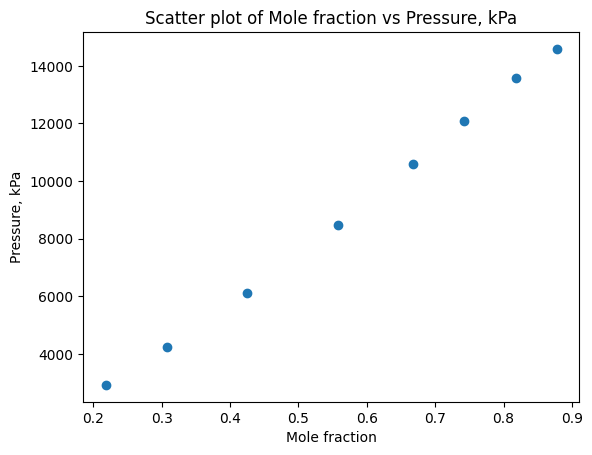

363.15
(198, 130)


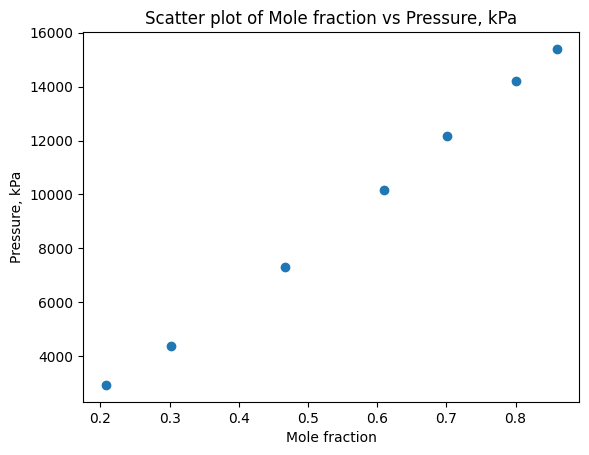

373.15
(198, 130)


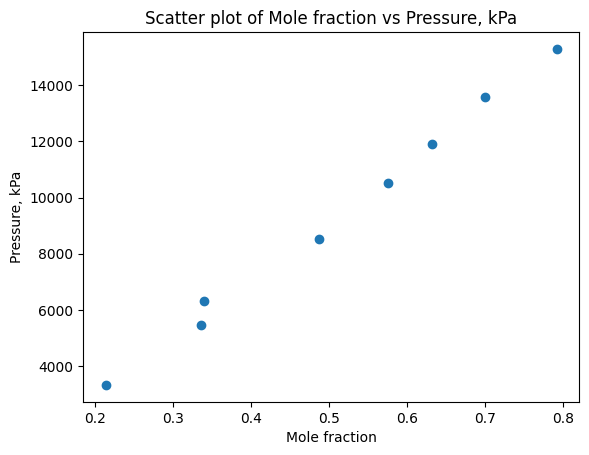

373.2
(198, 130)


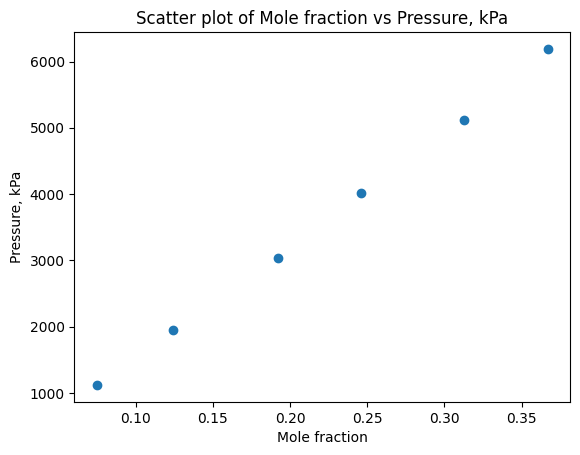

323.3
(198, 130)


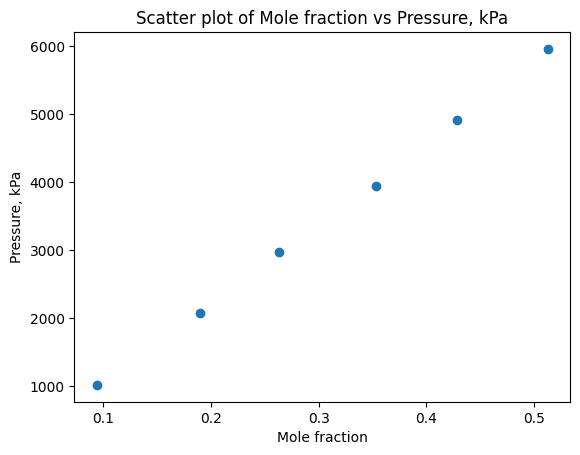

323.2
(198, 130)


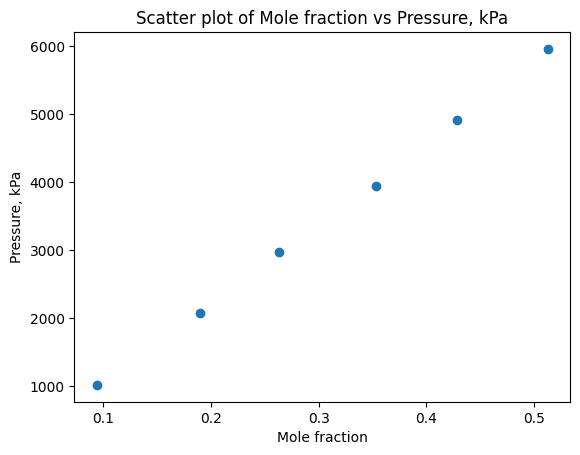

In [13]:

# print(filtered_df['Mole fraction'].isna().sum())
print(refined_df['Pressure, kPa'].isna().sum())
print(refined_df['Temperature, K'].isna().sum())
# plt.scatter(filtered_df['Mole fraction'], filtered_df['Pressure, kPa'])
# plt.xlabel('Mole Fraction')
# plt.ylabel('Pressure (kPa)')
# plt.title('Pressure vs. Mole Fraction')
# plt.grid(True)
# plt.show()

unique_temperatures = refined_df['Temperature, K'].unique()
# print(unique_temperatures)
f_comp = 'Mole fraction'
s_comp = 'Pressure, kPa'
# s_comp = 'Vapor or sublimation pressure, kPa'

valid_results = dict()
for temp in unique_temperatures:
    subset_df = refined_df[refined_df['Temperature, K'] == temp]
    if not subset_df[f_comp].isna().all() and not subset_df[s_comp].isna().all():
        # valid_results[temp] = {'Mole fraction': subset_df[f_comp], 'Pressure, kPa': subset_df[s_comp]
        # valid_temps.append(temp)
        valid_results[temp] = subset_df
        # print(temp)
        # print(subset_df['filename'].unique())
        # plot2(subset_df, f_comp, s_comp)

for temp, subset in valid_results.items():
    print(temp)
    f_comp = 'Mole fraction'
    # f_comp = 'Mole fraction_2'
    s_comp = 'Pressure, kPa'
    # s_comp = 'Vapor or sublimation pressure, kPa'
    if not subset[f_comp].isna().all() and not subset[s_comp].isna().all():
        plot2(subset, f_comp, s_comp)

In [22]:
filtered_df = refined_df.dropna(subset=['Temperature, K', 'Temperature, K_2'])

# Display the filtered DataFrame
# filtered_df
refined_df.dropna(subset=['Temperature, K_2'])
# refined_df.dropna(subset=['Vapor or sublimation pressure, kPa'])
# refined_df[refined_df['phase']=='Gas']

,filename,components,component_1_inchi,component_2_inchi,"Pressure, kPa","Temperature, K",Mole fraction,phase,component_3_inchi,component_4_inchi,Mole fraction Variable metadata,n_components,Mole fraction_2,phase_2,"Mass density, kg/m3","Viscosity, Pa*s","Vapor or sublimation pressure, kPa","Temperature, K_2","Critical pressure, kPa"
58,./mixture_data/j.jct.2012.08.019.xml,decane__carbon dioxide,"InChI=1S/C10H22/c1-3-5-7-9-10-8-6-4-2/h3-10H2,...",InChI=1S/C14H30/c1-3-5-7-9-11-13-14-12-10-8-6-...,1020.0,323.3,0.094,Liquid,"InChI=1S/C10H22/c1-3-5-7-9-10-8-6-4-2/h3-10H2,...",InChI=1S/C14H30/c1-3-5-7-9-11-13-14-12-10-8-6-...,carbon dioxide___,2,NaN,NaN,711.0,0.00056,NaN,323.2,NaN
59,./mixture_data/j.jct.2012.08.019.xml,decane__carbon dioxide,"InChI=1S/C10H22/c1-3-5-7-9-10-8-6-4-2/h3-10H2,...",InChI=1S/C14H30/c1-3-5-7-9-11-13-14-12-10-8-6-...,2080.0,323.3,0.190,Liquid,"InChI=1S/C10H22/c1-3-5-7-9-10-8-6-4-2/h3-10H2,...",InChI=1S/C14H30/c1-3-5-7-9-11-13-14-12-10-8-6-...,carbon dioxide___,2,NaN,NaN,716.0,0.00046,NaN,323.2,NaN
60,./mixture_data/j.jct.2012.08.019.xml,decane__carbon dioxide,"InChI=1S/C10H22/c1-3-5-7-9-10-8-6-4-2/h3-10H2,...",InChI=1S/C14H30/c1-3-5-7-9-11-13-14-12-10-8-6-...,2970.0,323.3,0.263,Liquid,"InChI=1S/C10H22/c1-3-5-7-9-10-8-6-4-2/h3-10H2,...",InChI=1S/C14H30/c1-3-5-7-9-11-13-14-12-10-8-6-...,carbon dioxide___,2,NaN,NaN,720.0,0.00042,NaN,323.2,NaN
61,./mixture_data/j.jct.2012.08.019.xml,decane__carbon dioxide,"InChI=1S/C10H22/c1-3-5-7-9-10-8-6-4-2/h3-10H2,...",InChI=1S/C14H30/c1-3-5-7-9-11-13-14-12-10-8-6-...,3940.0,323.3,0.353,Liquid,"InChI=1S/C10H22/c1-3-5-7-9-10-8-6-4-2/h3-10H2,...",InChI=1S/C14H30/c1-3-5-7-9-11-13-14-12-10-8-6-...,carbon dioxide___,2,NaN,NaN,724.0,0.00038,NaN,323.2,NaN
62,./mixture_data/j.jct.2012.08.019.xml,decane__carbon dioxide,"InChI=1S/C10H22/c1-3-5-7-9-10-8-6-4-2/h3-10H2,...",InChI=1S/C14H30/c1-3-5-7-9-11-13-14-12-10-8-6-...,4910.0,323.3,0.429,Liquid,"InChI=1S/C10H22/c1-3-5-7-9-10-8-6-4-2/h3-10H2,...",InChI=1S/C14H30/c1-3-5-7-9-11-13-14-12-10-8-6-...,carbon dioxide___,2,NaN,NaN,729.0,0.00033,NaN,323.2,NaN
63,./mixture_data/j.jct.2012.08.019.xml,decane__carbon dioxide,"InChI=1S/C10H22/c1-3-5-7-9-10-8-6-4-2/h3-10H2,...",InChI=1S/C14H30/c1-3-5-7-9-11-13-14-12-10-8-6-...,5960.0,323.3,0.513,Liquid,"InChI=1S/C10H22/c1-3-5-7-9-10-8-6-4-2/h3-10H2,...",InChI=1S/C14H30/c1-3-5-7-9-11-13-14-12-10-8-6-...,carbon dioxide___,2,NaN,NaN,735.0,0.00028,NaN,323.2,NaN


In [49]:
new_df = pd.DataFrame()

# Copy 'filename' column
new_df['filename'] = refined_df['filename'].copy()

# Rename 'Temperature, K' to 'temperature'
new_df['temperature'] = refined_df['Temperature, K']

# Rename 'Mole fraction' to 'liquid_fraction'
new_df['liquid_fraction'] = refined_df['Mole fraction']

# Rename 'Mole fraction_2' to 'gas_fraction'
new_df['gas_fraction'] = refined_df['Mole fraction_2']

new_df['density'] = refined_df['Mass density, kg/m3']
new_df['viscosity'] = refined_df['Viscosity, Pa*s']

# Merge ['Pressure, kPa', 'Vapor or sublimation pressure, kPa', 'Critical pressure, kPa'] into 'pressure'
pressure_cols = ['Pressure, kPa', 'Vapor or sublimation pressure, kPa', 'Critical pressure, kPa']
new_df['pressure'] = refined_df[pressure_cols].apply(lambda row: row.dropna().iloc[0] if row.count() > 0 else np.nan, axis=1)

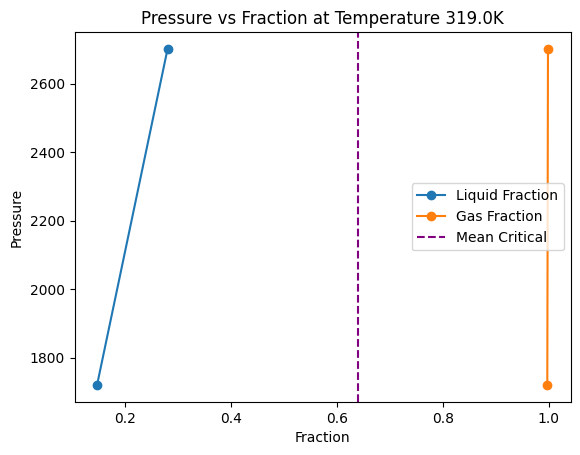

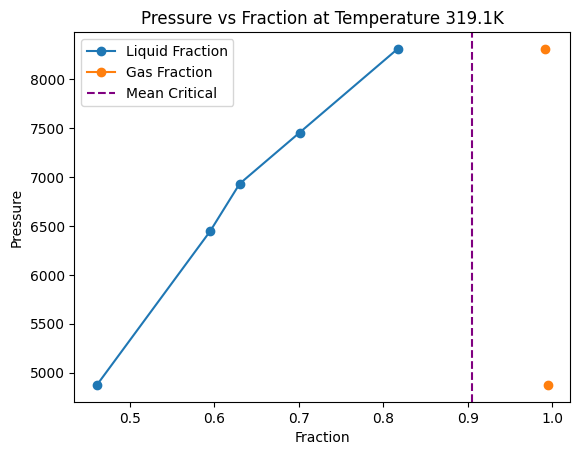

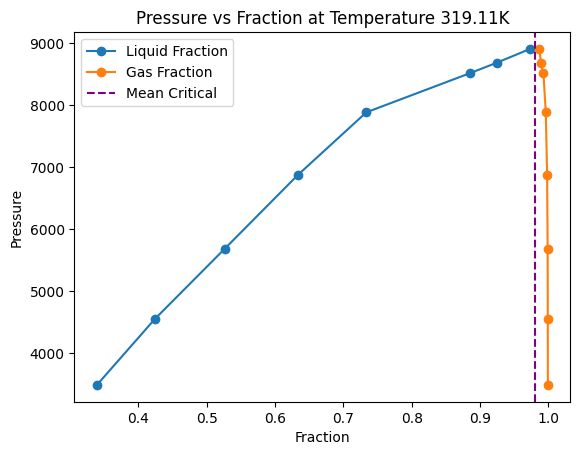

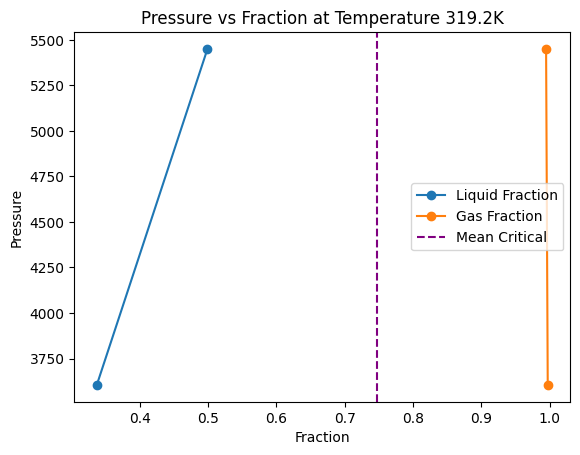

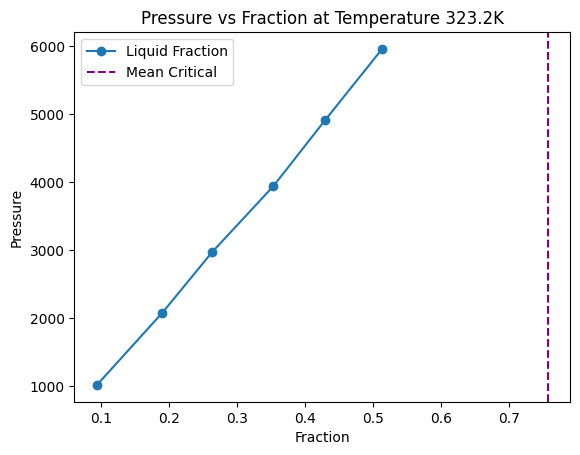

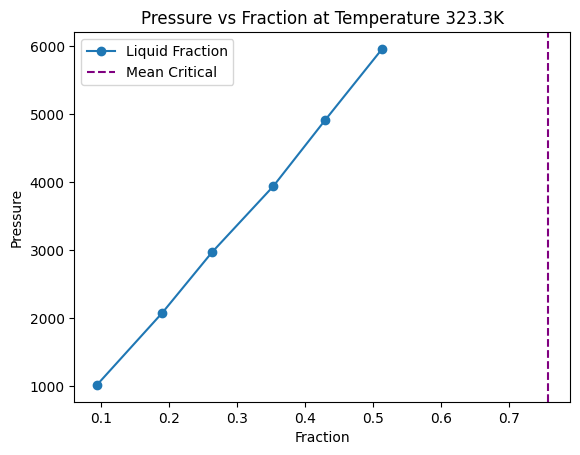

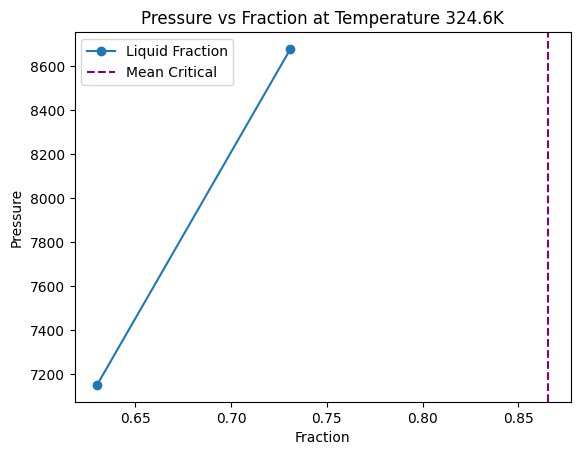

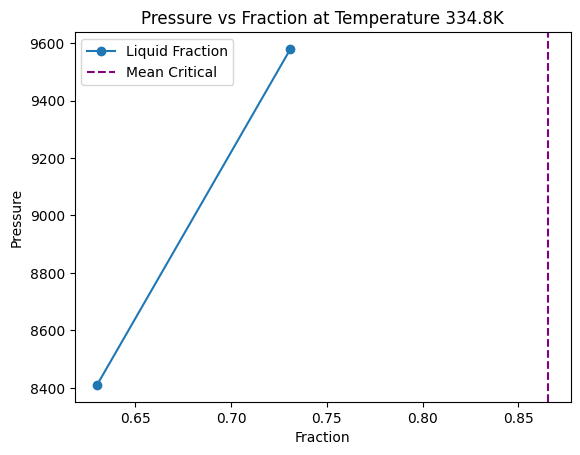

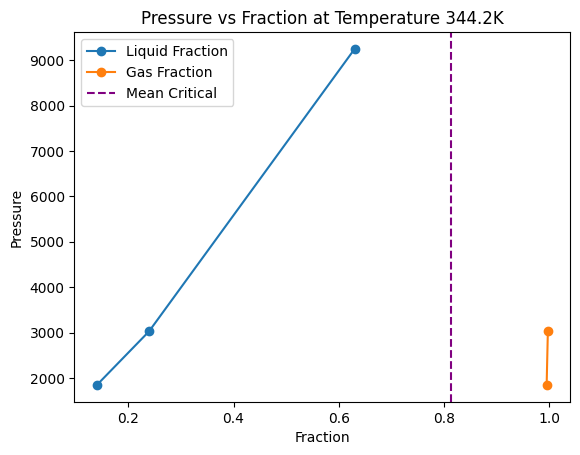

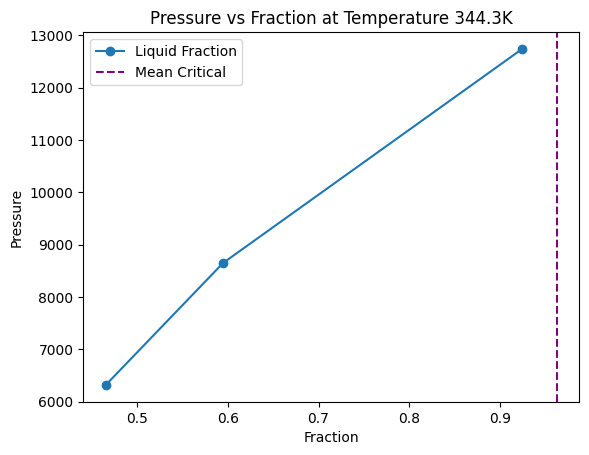

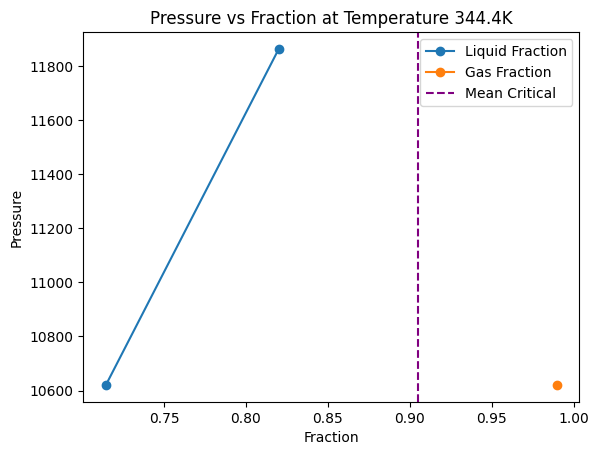

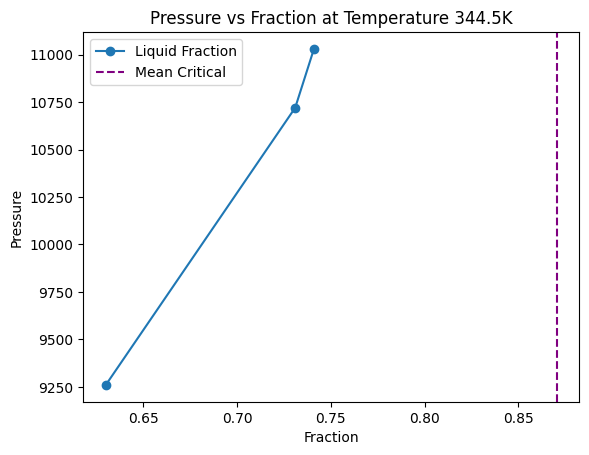

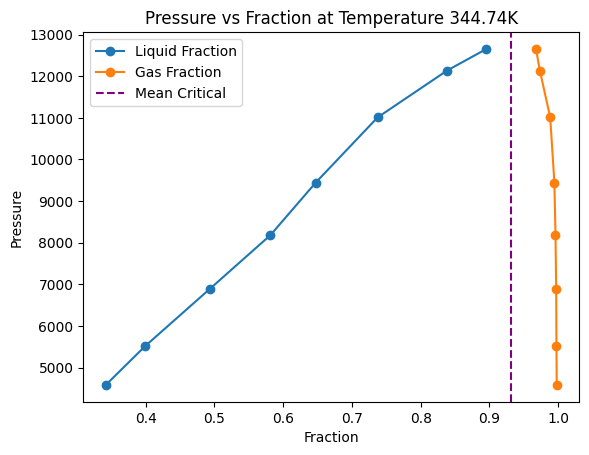

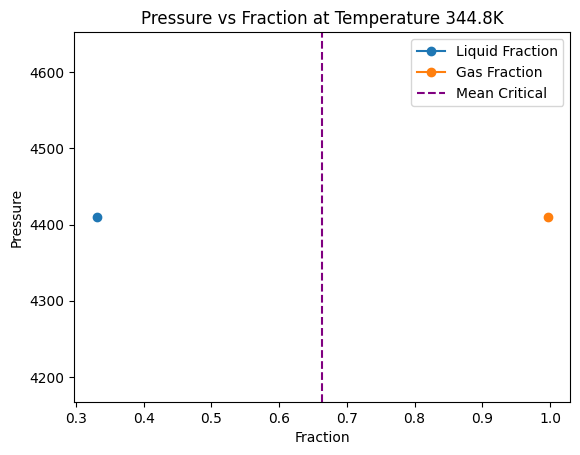

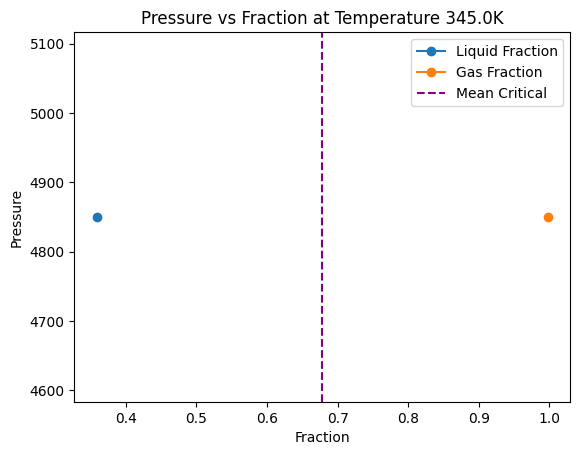

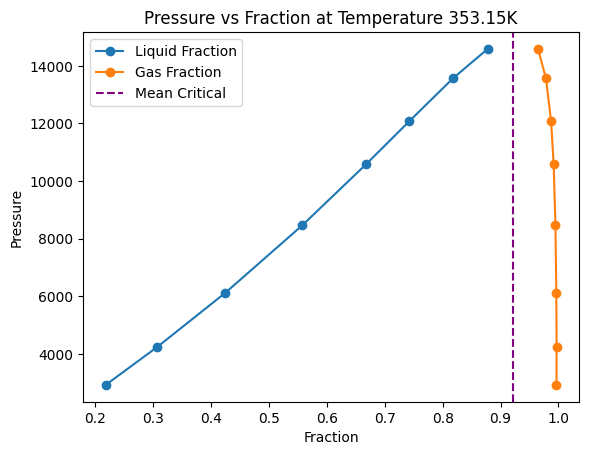

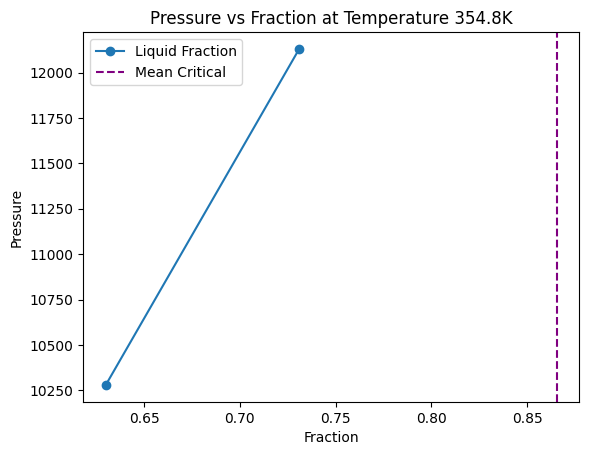

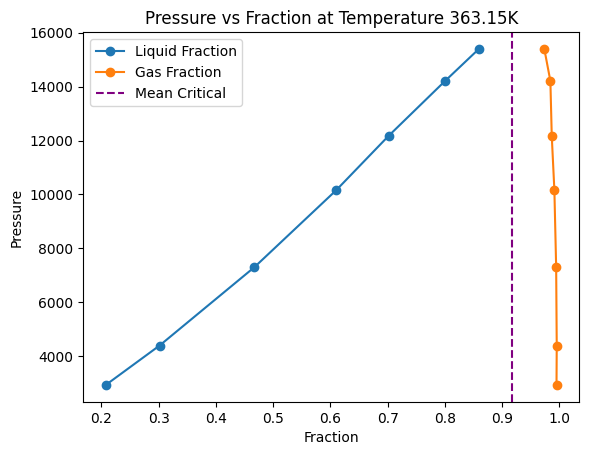

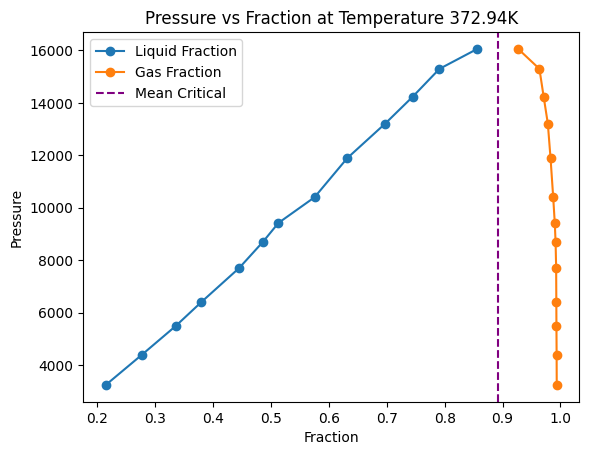

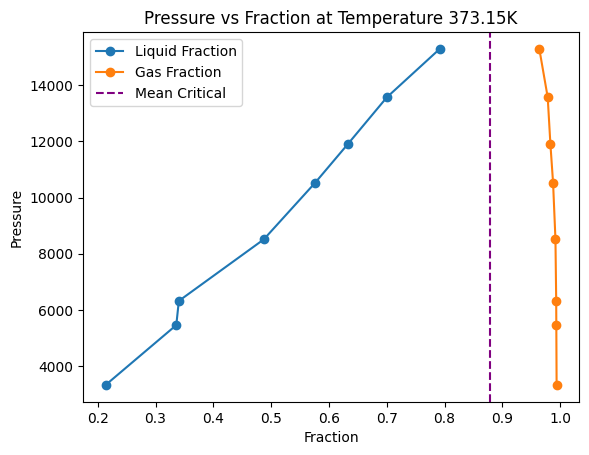

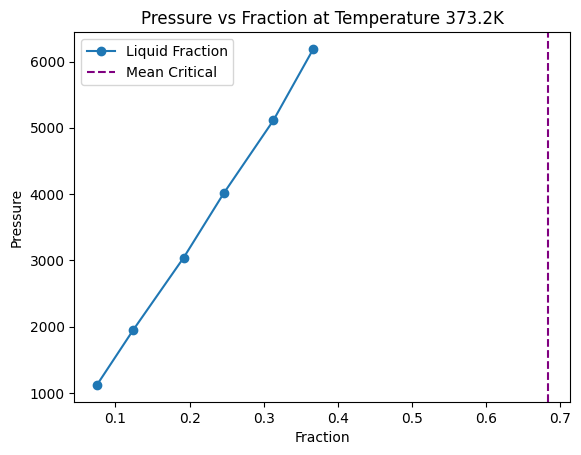

0.9731 0.9271


In [50]:
# Get unique temperatures
temperatures = new_df['temperature'].unique()
temperatures = sorted([temp for temp in temperatures if not np.isnan(temp)])
absml = 0.0
absmg = 1.0
mean_criticals = dict()

for temp in temperatures:
    # Filter data for the current temperature
    temp_df = new_df[new_df['temperature'] == temp].sort_values('pressure')

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Check if 'liquid_fraction' column exists and is not all NaN
    max_liquid = 0.0
    min_gas = 1.0
    if 'liquid_fraction' in temp_df.columns and not temp_df['liquid_fraction'].isna().all():
        # max_liquid = temp_df['liquid_fraction'].iloc[-1]
        max_liquid = temp_df['liquid_fraction'].loc[temp_df['liquid_fraction'].last_valid_index()]
        ax.plot(temp_df['liquid_fraction'], temp_df['pressure'], '-o', label='Liquid Fraction')

    # Check if 'gas_fraction' column exists and is not all NaN
    if 'gas_fraction' in temp_df.columns and not temp_df['gas_fraction'].isna().all():
        # min_gas = temp_df['gas_fraction'].iloc[-1]
        min_gas = temp_df['gas_fraction'].loc[temp_df['gas_fraction'].last_valid_index()]
        ax.plot(temp_df['gas_fraction'], temp_df['pressure'], '-o', label='Gas Fraction')

    absml = max(max_liquid, absml)
    absmg = min(min_gas, absmg)
    mean_critical = (max_liquid + min_gas)/2
    ax.axvline(x=mean_critical, color='purple', linestyle='--', label='Mean Critical')
    mean_criticals[temp] = mean_critical

    # Set labels and title
    ax.set_xlabel('Fraction')
    ax.set_ylabel('Pressure')
    ax.set_title(f'Pressure vs Fraction at Temperature {temp}K')

    # Show legend
    ax.legend()

    # Show the plot
    plt.show()

print(absml, absmg)


In [52]:
# new_df[new_df['temperature']==344.74]
# new_df[new_df['temperature']==344.8]
# new_df[new_df['temperature']==345]
new_df['mean_critical'] = new_df['temperature'].map(mean_criticals)
# print(mean_criticals)
new_df

,filename,temperature,liquid_fraction,gas_fraction,density,viscosity,pressure,mean_critical
0,./mixture_data/acs.jced.7b00517.xml,353.15,0.2179,0.9966,NaN,NaN,2920.0,0.9212
1,./mixture_data/acs.jced.7b00517.xml,353.15,0.3071,0.9968,NaN,NaN,4240.0,0.9212
2,./mixture_data/acs.jced.7b00517.xml,353.15,0.4246,0.9963,NaN,NaN,6120.0,0.9212
3,./mixture_data/acs.jced.7b00517.xml,353.15,0.5573,0.9948,NaN,NaN,8460.0,0.9212
4,./mixture_data/acs.jced.7b00517.xml,353.15,0.6675,0.9917,NaN,NaN,10580.0,0.9212
...,...,...,...,...,...,...,...,...
94,./mixture_data/je4000394.xml,323.20,0.1900,NaN,716.0,0.00046,2080.0,0.7565
95,./mixture_data/je4000394.xml,323.20,0.2630,NaN,720.0,0.00042,2970.0,0.7565
96,./mixture_data/je4000394.xml,323.20,0.3530,NaN,724.0,0.00038,3940.0,0.7565
97,./mixture_data/je4000394.xml,323.20,0.4290,NaN,729.0,0.00033,4910.0,0.7565


In [54]:
new_df.to_csv('pressure_fraction_graph_data.csv', index=False)

In [56]:
print(mean_criticals)

{319.0: 0.63985, 319.1: 0.9045, 319.11: 0.97995, 319.2: 0.7469, 323.2: 0.7565, 323.3: 0.7565, 324.6: 0.8654999999999999, 334.8: 0.8654999999999999, 344.2: 0.81345, 344.3: 0.962, 344.4: 0.9048, 344.5: 0.8705, 344.74: 0.9316, 344.8: 0.66395, 345.0: 0.67845, 353.15: 0.9212, 354.8: 0.8654999999999999, 363.15: 0.91665, 372.94: 0.89175, 373.15: 0.87765, 373.2: 0.6835}
